# Assignment 2 – Zero-Shot Image Classification with Transformers

In this assignment, you will apply a pre-trained vision–language transformer (e.g. CLIP) to perform **zero-shot** classification on the Fashion-MNIST dataset—classifying each image without any task-specific training. You will build on the concepts from Assignment 1 by comparing this “off-the-shelf” approach to the CNN you previously trained.

You will:
1. **Load** the Fashion-MNIST images using PyTorch instead of Keras.
2. **Run a zero-shot baseline** with simple text prompts to set a performance reference.
3. **Engineer improved prompts** and measure the resulting accuracy gains.
4. **Visualise image embeddings** with UMAP to inspect class separability.
5. **Conduct one mini-experiment** of your choice.
6. **Summarise findings** and reflect on strengths and weaknesses of zero-shot transformers versus a trained CNN.

# 1. Loading the Fashion-MNIST Dataset

As in assignment 1, we'll load the Fashion-MNIST dataset, but this time using `torchvision.datasets` to ensure compatibility with the `transformers` library. We will also load our model and processor from the `transformers` library.

The transformers library allows us to use pre-trained models like CLIP, which can perform zero-shot classification by leveraging the text prompts we provide. There are two key objects we will use: the `CLIPModel` for the model itself and the `CLIPProcessor` for preparing our images and text prompts.

Since we are not actually training a model in this assignment, we will set the CLIP model to evaluation mode. If the model is designed to utilize features like dropout or batch normalization, setting it to evaluation mode ensures that these features behave correctly during inference (prediction). Setting the model to evaluaton mode also tells PyTorch that we don't have to compute gradients, which can save memory and speed up inference.

In order to speed up processing, we will also move the model to an "accelerator" if available. This is typically a GPU, but modern MacBooks also have an "Apple Silicon" accelerator that can be used for inference, called MPS (Metal Performance Shaders). If you are using a MacBook with Apple Silicon, you can use the MPS device for faster processing.

In [9]:
# Uncomment and run if required
#!pip install transformers torchvision torch accelerate

In [1]:
from transformers import CLIPModel, CLIPProcessor
import torch

clip_model_name = "openai/clip-vit-base-patch32"
clip_model     = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name, use_fast=False)

# Set model to evaluation mode, as we are not training it
clip_model.eval()

# Check for accelerators
device = "cpu" # Default to CPU
if torch.cuda.is_available():
    device = "cuda" # Use GPU if available
elif torch.backends.mps.is_available():
    device = "mps"

clip_model.to(device)

print(f"Using device: {device}")

c:\Users\Uma\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Now we are ready to load the testing set from Fashion-MNIST. We will use the `torchvision.datasets.FashionMNIST` class to load the dataset. We do not need to apply any transformations to the images, as the `CLIPProcessor` ensures any input images are in the format that the model is trained on.

You should:

- [ ] Use the `torchvision.datasets.FashionMNIST` class to load the *test* split of the dataset. Documentation is available [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
- [ ] Create a PyTorch `DataLoader` to iterate over the dataset in batches. Use a batch size of 16 and set `shuffle=True` to randomise the order of the images. You will also need to supply the provided `collate_clip` function to the `DataLoader collate_fn` argument to ensure the images are processed correctly. Documentation for `DataLoader` is available [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [2]:
from torchvision import datasets
from torch.utils.data import DataLoader

CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

def collate_clip(batch):
    imgs, labels = zip(*batch) # Unzip the batch into images and labels
    proc = clip_processor(images=list(imgs),
                        return_tensors="pt",
                        padding=True) # Process images with CLIPProcessor
    # Send pixel_values to GPU/CPU now; labels stay on CPU for metrics
    return proc["pixel_values"].to(device), torch.tensor(labels)



In [3]:
test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_clip
)

print("Test DataLoader ready!")

Test DataLoader ready!


If your code is correct, the following cell should show the first batch of images from the Fashion-MNIST dataset:

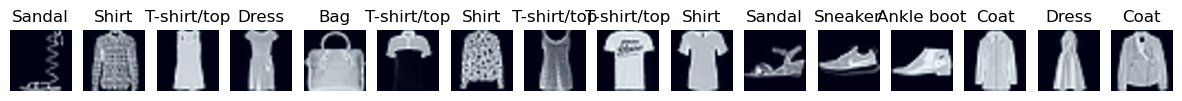

In [4]:
import matplotlib.pyplot as plt

# Display the first batch of images from `test_loader`

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()  # Move images to CPU for plotting
    # Renormalize to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(CLASS_NAMES[label.item()])
        ax.axis('off')
    plt.show()

show_batch(test_loader)

We’re now ready to run our zero-shot classification baseline!

# Brief Introduction to Zero-Shot Classification

In Assignment 1, we followed the typical machine-learning pipeline: we trained a CNN on the Fashion-MNIST dataset, using labelled examples to update the model’s weights. While effective, that approach requires a curated, task-specific training set—a luxury you don’t always have in practice.

Zero-shot classification flips the script.  A large vision–language model (VLM) such as **CLIP** is first pre-trained on hundreds of millions of image–text pairs scraped from the web.  Because it learns *joint* visual–textual embeddings, the model can later solve new tasks simply by “measuring” how similar an image is to a **text prompt** that describes each candidate class—without seeing a single task-labelled example.

**How it works**  
1. Feed an image through CLIP’s vision encoder → **image feature**.  
2. Feed a textual prompt (e.g. “a photo of a sandal”) through CLIP’s text encoder → **text feature**.  
3. Compute cosine similarity between the image feature and every class’s text feature.  
4. Pick the class whose prompt is most similar.

For our first attempt, we’ll use the bare class names as prompts, e.g.:

- "T-shirt/top"
- "Trouser"

### You should:

- [ ] Build embeddings: use the `get_text_embeddings` helper function to create text embeddings for the class names.
- [ ] Run inference: use the `get_image_embeddings` helper function to create image embeddings.
- [ ] Compute cosine similarity: complete and use the `get_cosine_similarity` helper function to compute the cosine similarity between the image and text embeddings.
- [ ] Make predictions: use the `get_predictions` helper function to get the predicted class for each image in the batch.

Note that for normalized vectors like the ones we are using, cosine similarity is equivalent to the dot product. This means we can use the handy formula `cosine_similarity = vector_a @ vector_b.T` to compute the similarity between the image and text embeddings.

In [5]:
def get_text_embeddings(class_names: list[str]) -> torch.Tensor:
    """    Get text embeddings for the given class names using CLIP.
    Args:
        class_names (list[str]): List of class names to encode.
    Returns:
        torch.Tensor: Normalized text embeddings for the class names.
    """
    
    tokenized = clip_processor(text=class_names,
                               padding=True,
                               return_tensors="pt").to(device)
    
    with torch.no_grad():
        text_embeddings = clip_model.get_text_features(**tokenized)

    text_feats = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    return text_feats

def get_image_embeddings(images: torch.Tensor) -> torch.Tensor:
    """    Get image embeddings for the given images using CLIP.
    Args:
        images (torch.Tensor): Batch of images to encode.
    Returns:
        torch.Tensor: Normalized image embeddings for the images.
    """
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=images)

    image_feats = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return image_feats

In [6]:

import numpy as np


def get_cosine_similarity(image_feats: torch.Tensor, text_feats: torch.Tensor) -> np.ndarray:
    """
    Compute cosine similarity between image features and text features.
    Args:
        image_feats (torch.Tensor): Image features of shape (N, D).
        text_feats (torch.Tensor): Text features of shape (M, D).
    Returns:
        numpy.ndarray: Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    """
    image_feats = image_feats.cpu()  # Ensure image features are on CPU
    text_feats = text_feats.cpu()    # Ensure text features are on CPU

    # Compute cosine similarity, which is the dot product of normalized vectors
    # Normalize feature
    image_feats = image_feats / image_feats.norm(dim=1, keepdim= True)
    text_feats = text_feats / text_feats.norm(dim=1, keepdim=True) 
    # Ensure they are 2D (N, D) and (M, D)
                                            
    # compute cosine similarity
    similarity = image_feats@ text_feats.T
    return similarity.numpy()  # Complete


def get_predictions(similarity: np.ndarray) -> np.ndarray:
    """
    Get predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,).
    """
    # Get the index of the maximum similarity for each image
    #code here need to write 
    return np.argmax(similarity, axis=1)

With these functions complete, you are ready to run the zero-shot classification baseline. Complete the code to follow these steps:

- [ ] Build text embeddings for the class names using the `get_text_embeddings` function (this only needs to be done once).
- [ ] For each batch of images:
    - [ ] Get image embeddings using the `get_image_embeddings` function.
    - [ ] Compute cosine similarity between the image and text embeddings using the `get_cosine_similarity` function.
    - [ ] Save the predictions so that we can build a confusion matrix later.
- [ ] Report the accuracy of the predictions and the confusion matrix using the `accuracy_score` and `confusion_matrix` functions from `sklearn.metrics`.

Accuracy: 62.400000%


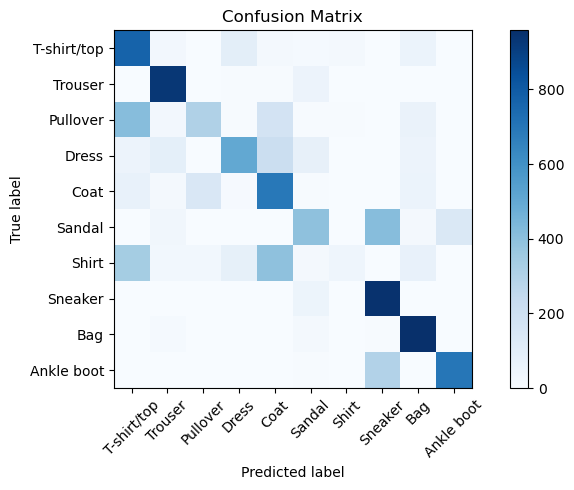

In [7]:
CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

y_true, y_pred = [], []

for pixel_values, labels in test_loader:

# Need to write code
# get_text embeddings
    text_feats = get_text_embeddings(CLASS_NAMES)
# get_image_embeddings function.
    image_feats = get_image_embeddings(pixel_values)                                    
# get_cosine_similarity function.
    similarity = get_cosine_similarity(image_feats, text_feats)
 #  Save the predictions so that we can build a confusion matrix later.
    preds = get_predictions(similarity)
  
    # Save labels and predictions
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Report the accuracy of the predictions
accuracy =accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:2f}%')

# Report the confusion matrix
def plot_confusion_matrix(y_true, y_pred, CLASS_NAMES):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(CLASS_NAMES))
    plt.xticks(tick_marks, CLASS_NAMES, rotation=45)
    plt.yticks(tick_marks, CLASS_NAMES)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

#Call the function to display the confusion matrix
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)

   

Reflection: Consider the results. How does the performance of this zero-shot baseline compare to the CNN you trained in Assignment 1? What are the strengths and weaknesses of this approach?


My comment:
Accuracy compared to CNN model is very low. Accuracy in CNN model was app 91% while base line model 
Accuracy is high & depend on trained task.  While in Zero fit classification, accuracy is low, it depends on prompt quality.


## Improving Zero-Shot Classification with Prompt Engineering

In the previous section, we directly used the class names as text prompts for zero-shot classification. However, we can often improve performance by crafting more descriptive prompts that better capture the visual characteristics of each class. For example, instead of just "T-shirt/top", we could use "a photo of a T-shirt" or "a photo of a top". This additional context can help the model make more accurate predictions.

In this section, we will experiment with more detailed prompts for each class to see if we can improve the zero-shot classification performance. You should:

- [ ] Create a list of improved prompts for each class. For example, instead of just "T-shirt/top", you could use "a photo of a T-shirt" or "a photo of a top".
- [ ] Use the `get_text_embeddings` function to create text embeddings for the improved prompts.
- [ ] Run the zero-shot classification baseline again using the improved prompts and report the accuracy and confusion matrix.

Note: Take advantage of the confusion matrix above. If two classes are often confused, consider how you might improve the prompts to help the model distinguish them better.

The aim for this section is for you to improve the performance of the model. However, if you find that the performance does not improve significantly, you can still reflect on the process and consider how you might further refine the prompts with more effort.

Accuracy: 62.760000%


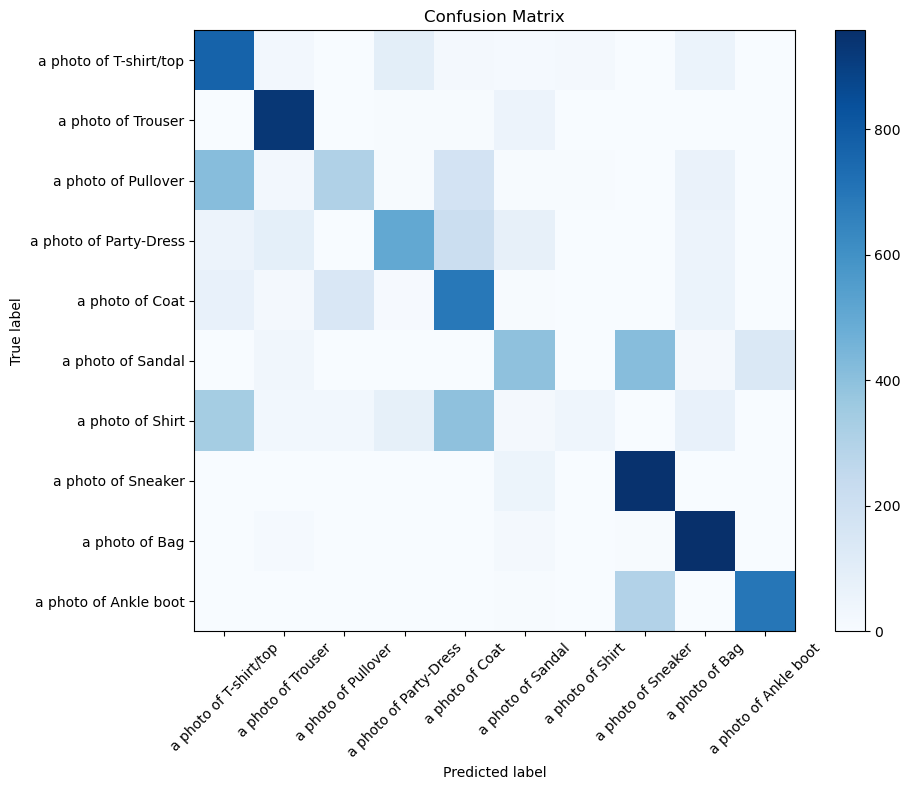

In [15]:
# improve model 
CLASS_NAMES_improved = [
    "a photo of T-shirt/top",
    "a photo of Trouser",
    "a photo of Pullover",
    "a photo of Party-Dress",
    "a photo of Coat",
    "a photo of Sandal",
    "a photo of Shirt",
    "a photo of Sneaker",
    "a photo of Bag",
    "a photo of Ankle boot"
]
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

y_true_improved, y_pred_improved = [], []

# get_text embeddings
# moved outside the loop
text_feats_improved = get_text_embeddings(CLASS_NAMES_improved)

for pixel_values, labels in test_loader:

# Need to write code

# get_image_embeddings function.
    image_feats_improved = get_image_embeddings(pixel_values)    

# get_cosine_similarity function.
    similarity = get_cosine_similarity(image_feats_improved, text_feats_improved)# get_text embeddings
 
 #  Save the predictions so that we can build a confusion matrix later.
    preds = get_predictions(similarity)
  
    # Save labels and predictions
    y_true_improved.extend(labels.numpy())
    y_pred_improved.extend(preds)

# Report the accuracy of the predictions
accuracy =accuracy_score(y_true_improved, y_pred_improved)
print(f'Accuracy: {accuracy * 100:2f}%')

# Report the confusion matrix
def plot_confusion_matrix(y_true_improved, y_pred_improved, CLASS_NAMES_improved):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(CLASS_NAMES_improved))
    plt.xticks(tick_marks, CLASS_NAMES_improved, rotation=45)
    plt.yticks(tick_marks, CLASS_NAMES_improved)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_true_improved, y_pred_improved, CLASS_NAMES_improved)


Reflection: How did your detailed prompts affect the zero-shot classification performance? Did you see a significant improvement compared to the baseline? What insights did you gain about the model's understanding of the classes? Do you think that with more effort you could further improve the performance? If so, how?

The detailed prompts affect the zero-shot classification performance better than the baseline Zero-shot calssification. Some improvement in accuracy from 61.40% to 62.81%.
Adding descriptive context guides CLIP's attention to the visual characteristics of each class.
Multiple prompt for each class can boost accuracy.



## Visualizing Image Embeddings with UMAP

To better understand how the model perceives the different classes, we can visualize the image embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us see how similar or dissimilar the embeddings are in a lower-dimensional space.

By visualizing the embeddings, we can gain insights into how well the model can distinguish certain images, even without considering the text prompts. This can help us identify clusters of similar images and see if there are any overlaps between classes.

You should:

- [ ] Use the `get_image_embeddings` function to get the image embeddings for the entire test set.
- [ ] Use UMAP to reduce the dimensionality of the image embeddings to 2D.
- [ ] Plot the 2D embeddings, coloring each point by its true class label.

You may need to install the `umap-learn` library if you haven't already. You can do this by running `pip install umap-learn`.

In [9]:
# Uncomment the following line to install UMAP if you haven't already
# !pip install umap-learn
# ploting of samples on to 2 dimesional plot , how saparable your data

Image embedding shape: (10000, 512)
Label shape: (10000,)


c:\Users\Uma\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


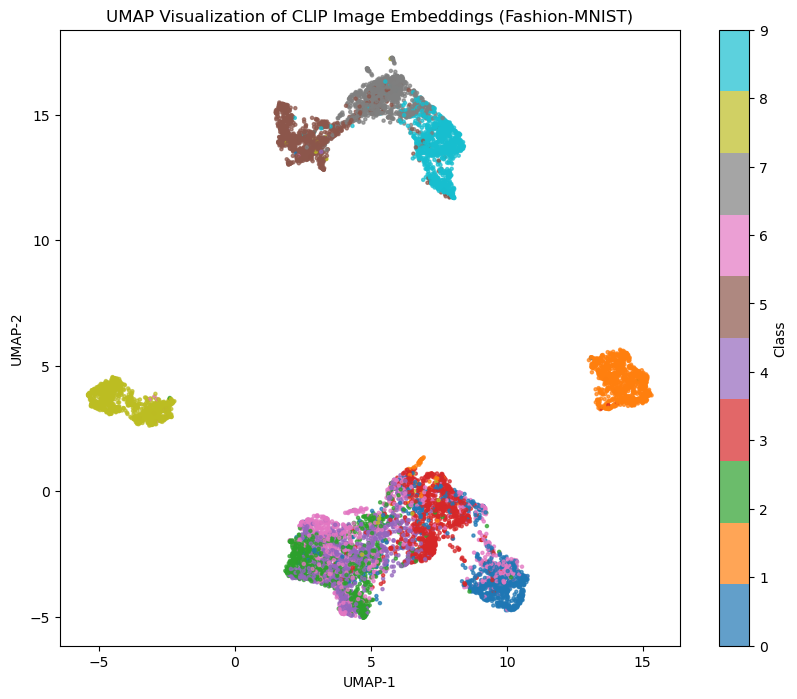

In [13]:

import umap
import torch
from umap import UMAP
import numpy as np
import matplotlib.pyplot as plt

CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# ------------------------------------------------------------
# 1. Collect image embeddings, (expecting images-UD)
# ------------------------------------------------------------
all_img_emb = []
all_labels  = []
for pixel_values, labels in test_loader:
    pixel_values = pixel_values.to(device)
    with torch.no_grad():
        img_embeds = get_image_embeddings(pixel_values)
    all_img_emb.append(img_embeds.cpu())
    all_labels.append(labels)                                   

# ------------------------------------------------------------
# 2. Fit UMAP
# ------------------------------------------------------------
# Concatenate all batches

all_img_emb = torch.cat(all_img_emb, dim=0).numpy() # shape: (num_samples, embedding_dim)
all_labels = torch.cat(all_labels, dim=0).numpy() # shape: (num_samples)

print("Image embedding shape:", all_img_emb.shape)
print("Label shape:", all_labels.shape)

umap_model = UMAP(n_components=2, random_state=42)
img_emb_2d = umap_model.fit_transform(all_img_emb)

# ------------------------------------------------------------
# 3. Plot coloured by ground-truth label
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    img_emb_2d[:, 0], img_emb_2d[:, 1],
    c=all_labels, cmap='tab10', s=5, alpha=0.7
)
plt.colorbar(scatter, ticks=range(len(CLASS_NAMES)), label='Class')
plt.title("UMAP Visualization of CLIP Image Embeddings (Fashion-MNIST)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

The UMAP embeddings allow us to see how separable or non-separable different classes are with our specific model. If two specific images are very similar, then they will be placed near each other on this graph. 

Reflection: Do you notice any challenges in distinguishing images based on this figure? Are there any types of clothing in the dataset which the model has no trouble distinguishing from the others?

Ans:::::The UMAP visualization revealed distinct clusters for easily separable classes like sneakers and bags,
showing that CLIP's image encoder captures meaningful visual structure. some overlapping shows between visually similar categories. UMAP helps to understand how the model organizes visual concepts, also demonstrate the challenges of separation of fine-grained fashion categories with out color.



## Mini-Experiment

In this section, you will conduct a mini-experiment of your choice to further explore the capabilities of zero-shot classification with transformers. This can be anything you'd like, but here are some ideas to get you started.

### A. Alternative Model

So far we have been utilizing OpenAI's CLIP model for zero-shot classification. However, there are many other vision–language models available in the `transformers` library that you can experiment with. For example, there are larger CLIP models such as [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14), and open-source versions such as [laion/CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K). You can also search huggingface [here](https://huggingface.co/models?sort=trending&search=clip) to find other models that might be suitable for zero-shot classification.

You can try using a different model to see if it improves the zero-shot classification performance. You should:
- [ ] Load a different model and processor from the `transformers` library.
- [ ] Run the zero-shot classification baseline with the new model and report the accuracy and confusion matrix.
- [ ] Reflect on the performance of the new model compared to the original CLIP model
  - How does the new model perform compared to the original CLIP model?
  - Do you notice any differences in the types of errors made by the new model?

### B. Multiple-Description Classification

Another interesting experiment is to explore multiple-description classification. *This involves providing multiple text prompts for each class, allowing the model to choose the most relevant one. For example, instead of just "T-shirt/top", you could provide "a photo of a T-shirt", "a photo of a top", and "a photo of a shirt". This can help the model better understand the class and increases the likelihood of a correct prediction. You should:

- [ ] Create a list of multiple prompts for each class.
- [ ] Use the `get_text_embeddings` function to create text embeddings for the multiple prompts.
- [ ] Run the zero-shot classification baseline again using the multiple prompts and report the accuracy and confusion matrix.
- [ ] Consider the model to be correct if it guesses *any* of the prompts belonging to the correct class.

### C. Top-K Classification

In some classification tasks, it can be useful to consider if the right answer is among the top K (e.g. top 3) predictions. This can be particularly useful in cases where the model is uncertain or when there are multiple similar classes. You should:

- [ ] Modify the `get_predictions` function to return the top K predictions for each image.
- [ ] Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions.
- [ ] Report the accuracy and confusion matrix for the top K predictions. Report at least two different values of K (e.g. K=2 and K=4).

### D. Other Ideas

You are welcome to come up with your own mini-experiment! Explain your idea in the report and implement it. Did it work as you expected? What did you learn from it?

In [14]:
CLASS_NAME_PROMPTS = { 
    "T-Shirt/top":[
        "a photo of T-shirt",
        "a photo of casual top",
        "a photo of shirt with long sleeves"
    ],
     "Trouser":[
        "a photo of trousers",
        "a photo of casual pants",
        "a photo of pants"
    ],
    "Pullover":[
        "a photo of pullover sweater ",
        "a photo of cozy sweater",
        "a photo of sweatshirt"
    ],
     "Dress":[
        "a photo of party dress",
        "a photo of long dress",
        "a photo of casual dress"
    ],
    "Coat":[
        "a photo of winter coat",
        "a photo of jacket",
        "a photo of overcoat"
    ],
    "Sandal": [
        "a photo of sandals",
        "a photo of flip-flops",
        "a photo of open shoes"
    ],
    "Shirt": [
        "a photo of casual shirt",
        "a photo of long-sleeve shirt",
        "a photo of dress shirt"
    ],
    "Sneaker": [
        "a photo of sneakers",
        "a photo of running shoes",
        "a photo of sports shoes"
    ],
    "Bag": [
        "a photo of bag",
        "a photo of small handbag",
        "a photo of purse"
    ],
    "Ankle boot": [
        "a photo of ankle boots",
        "a photo of boots",
        "a photo of leather boots"
    ]
}

from numpy import mean
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt

# function for multifrm text embedding
def get_multi_prompt_text_embeddings(prompt_dict):
    """
    Generate averaged text embeddings for each class using multiple prompts.
    Returns a tensor of shape (num_classes, embedding_dim)
    """
    all_class_embeddings = []
    for class_name, prompts in prompt_dict.items():
        # embedding for all prompts in this class
        prompt_embeds = get_text_embeddings(prompts) # (num_prompts, embedding-din)
        # average embedding for that class
        avg_embed =prompt_embeds.mean(dim=0)
        all_class_embeddings.append(avg_embed)
    return torch.stack(all_class_embeddings)  # shape: (num_classes, embedding_dim)

   
#  Create the text embeddings
text_feats_PROMPT = get_multi_prompt_text_embeddings(CLASS_NAME_PROMPTS)

y_true_PROMPT, y_pred_PROMPT = [], []

for pixel_values, labels in test_loader:
# get_image_embeddings function.
    image_feats_PROMPT = get_image_embeddings(pixel_values)                                    
# get_cosine_similarity function.
    similarity = get_cosine_similarity(image_feats_PROMPT, text_feats_PROMPT)# get_text embeddings
 #  Save the predictions so that we can build a confusion matrix later.
    preds = get_predictions(similarity)
    # Save labels and predictions
    y_true_PROMPT.extend(labels.numpy())
    y_pred_PROMPT.extend(preds)

# Report the accuracy of the predictions
accuracy =accuracy_score(y_true_PROMPT, y_pred_PROMPT)
print(f'Accuracy: {accuracy * 100:2f}%')





Accuracy: 63.260000%


### Short Report

In this section, you will write a short report summarizing your findings from the mini-experiment. The report should include the following sections:

- **Introduction**: Briefly describe the mini-experiment you conducted and its objectives.
- **Methodology**: Explain the steps you took to conduct the experiment, including any modifications you made to the code or model.
- **Results**: Present the results of your experiment.
- **Discussion**: Reflect on the performance of the model and the implications of your findings. Consider the strengths and weaknesses of zero-shot transformers versus a trained CNN.

Short Report 

The mini-experiment I conducted is # B. Multiple-Description Classification.
 and its objectives was improving the model by providing multi texture description for each class


- convert prompt into vector
- average embedding across prompts for the class & save embedding for later use
- combine all embedding into single tensor shape for later similarity comparison
-each class has multiple prompts, therefore use multiple prompt text embedding.
- then follow the same method and code as improving Zero-shot model with improving engineering., replacing improved with prompt

Accuracy improved little bit (~2%), still low  since this model not specially trained on Fashion-MNIST. May be struggle with subtitle difference.


🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 02/11/2025`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb)
    * The Lab 4 notebook (labs/lab_4.ipynb)
    * The Lab 5 notebook (labs/lab_5.ipynb)
    * The Lab 6 notebook (labs/lab_6.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-7-help-ml`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.